# Thermal equilibrium of a single particle

In a large ensemble of identical systems each member will have a different state due to thermal fluctuations, even if all the systems were initialised in the same initial state.

As we integrate the dynamics of the ensemble we will have a distribution of states (i.e. the states of each member of the system). However, as the ensemble evolves, the distribution over the states eventually reaches a stationary distribution: the Boltzmann distribution. Even though the state of each member in the ensemble contitues to fluctuate, the ensemble as a whole is in a stastistical equilibrium (thermal equilibrium).

For an ensemble of single particles, we can compute the Boltzmann distribution by hand. In this example, we compare the analytical solution with the result of simulating an ensemble with Magpy.

#### Problem setup

A single particle has a uniaxial anisotropy axis $K$ and a magnetic moment of three components (x,y,z components). The angle $\theta$ is the angle between the magnetic moment and the anisotropy axis.

![Diagram of a single particle](single-particle-diagram.png)

#### Boltzmann distribution

The Boltzmann distribution represents of states over the ensemble; here the state is the **solid angle** $\phi=\sin(\theta)$ (i.e. the distribution over the surface of the sphere). The distribution is parameterised by the temperature of the system and the energy landscape of the problem.

$$p(\theta) = \frac{\sin(\theta)e^{-E(\theta)/(K_BT)}}{Z}$$

where $Z$ is called the partition function:

$$Z=\int_\theta \sin(\theta)e^{-E(\theta)/(K_BT)}\mathrm{d}\theta$$


#### Stoner-Wohlfarth model

The energy function for a single domain magnetic nanoparticle is given by the Stoner-Wohlfarth equation:

$$\frac{E\left(\theta\right)}{K_BT}=-\sigma\cos^2\theta$$

where $\sigma$ is called the normalised anisotropy strength:

$$\sigma=\frac{KV}{K_BT}$$

## Functions for analytic solution

In [1]:
import numpy as np

# anisotropy energy of the system
def anisotropy_e(theta, sigma):
    return -sigma*np.cos(theta)**2

In [2]:
# numerator of the Boltzmann distribution
# (i.e. without the partition function Z)
def p_unorm(theta, sigma):
    return np.sin(theta)*np.exp(-anisotropy_e(theta, sigma))

We use the quadrature rule to numerically evaluate the partition function $Z$.

In [3]:
from scipy.integrate import quad

# The analytic Boltzmann distribution
def boltzmann(thetas, sigma):
    Z = quad(lambda t: p_unorm(t, sigma), 0, thetas[-1])[0]
    distribution = np.array([
        p_unorm(t, sigma) / Z for t in thetas
    ])
    return distribution

### Energy landscape

We can plot the energy landscape (energy as a function of the system variables)

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

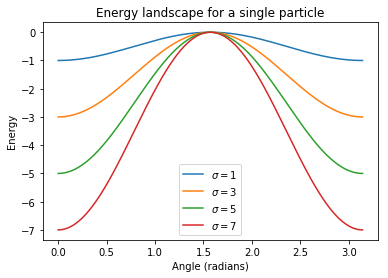

In [5]:
thetas = np.linspace(0, np.pi, 1000)
sigmas = [1, 3, 5, 7]

e_landscape = [anisotropy_e(thetas, s) for s in sigmas]
for s, e in zip(sigmas, e_landscape):
    plt.plot(thetas, e, label='$\sigma={}$'.format(s))
plt.legend(); plt.xlabel('Angle (radians)'); plt.ylabel('Energy')
plt.title('Energy landscape for a single particle');

We observe that:
 - The energy of the system has two minima: one alongside each direction of the anisotropy axis.
 - The minima are separated by a maxima: perpendicular to the anisotropy axis.
 - Stronger anisotropy increases the size of the energy barrier between the two minima.

### Equilibrium distribution (Boltzmann)

We can also plot the equilibrium distribution of the system, which is the probability distribution over the system states in a large ensemble of systems.

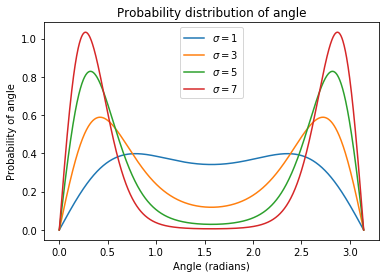

In [6]:
p_dist = [boltzmann(thetas, s) for s in sigmas]

for s, p in zip(sigmas, p_dist):
    plt.plot(thetas, p, label='$\sigma={}$'.format(s))
plt.legend(); plt.xlabel('Angle (radians)')
plt.ylabel('Probability of angle')
plt.title('Probability distribution of angle');

What does this mean? If we had an ensemble of single particles, the distribution of the states of those particles varies greatly depending on $\sigma$. Remember we can decrease $\sigma$ by reducing the anisotropy strength or particle size or by increasing the temperature.
 - When $\sigma$ is high, most of the particles in the ensemble will be found closely aligned with the anisotropy axis.
 - When $\sigma$ is low, the states of the particles are more evenly distributed.

## Magpy equilibrium

Using Magpy, we can simulate the dynamics of the state of a single nanoparticle. If we simulate a large ensemble of these systems for 'long enough', the distribution of states will reach equilibrium. If Magpy is implemented correctly, we should recover the analytical distribution from above.

### Set up the model

Select the parameters for the single particle

In [7]:
import magpy as mp

# These parameters will determine the distribution
K = 1e5
r = 7e-9
T = 300
kdir = [0., 0., 1.]

# These parameters affect the dynamics but
# have no effect on the equilibrium
Ms = 400e3
location = [0., 0., 0.]
alpha=1.0
initial_direction = [0., 0., 1.]

# Normalised anisotropy strength KV/KB/T
V = 4./3 * np.pi * r**3
kb = mp.core.get_KB()
sigma = K * V / kb / T
print(sigma)

34.68792671050298


In [8]:
import magpy as mp

single_particle = mp.Model(
    anisotropy=[K],
    anisotropy_axis=[kdir],
    damping=alpha,
    location=[location],
    magnetisation=Ms,
    magnetisation_direction=[initial_direction],
    radius=[r],
    temperature=T
)

### Create an ensemble

From the single particle we create an ensemble of 10,000 identical particles.

In [9]:
particle_ensemble = mp.EnsembleModel(
    base_model=single_particle, N=10000
)

### Simulate

Now we simulate! We don't need to simulate for very long because $\sigma$ is very high and the system will reach equilibrium quickly.

In [10]:
res = particle_ensemble.simulate(
    end_time=1e-9, time_step=1e-12, max_samples=50,
    random_state=1001, implicit_solve=True
)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:  3.1min finished


### Check that we have equilibriated

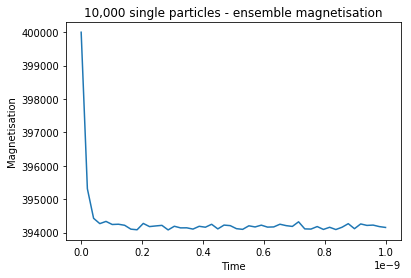

In [11]:
plt.plot(res.time, res.ensemble_magnetisation())
plt.title('10,000 single particles - ensemble magnetisation')
plt.xlabel('Time'); plt.ylabel('Magnetisation');

We can see that the system has reached a local minima. We could let the simulation run until the ensemble relaxes into both minima but it would take a very long time because the energy barrier is so high in this example.

### Compute theta

The results of the simulation are x,y,z coordinates of the magnetisation of each particle in the ensemble. We need to convert these into angles.

In [12]:
M_z = np.array([state['z'][0] for state in res.final_state()])
m_z = M_z / Ms
simulated_thetas = np.arccos(m_z)

### Compare to analytical solution

Now we compare our empirical distribution of states to the analytical distribution that we computed above.

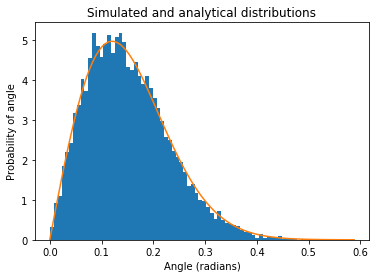

In [13]:
theta_grid = np.linspace(0.0, simulated_thetas.max(), 100)
analytical_probability = boltzmann(theta_grid, sigma)

plt.hist(simulated_thetas, normed=True, bins=80, label='Simulated');
plt.plot(theta_grid, analytical_probability, label='Analytical')
plt.title('Simulated and analytical distributions')
plt.xlabel('Angle (radians)'); plt.ylabel('Probability of angle');

The results look good! We could simulate an even bigger ensemble to produce a smoother empirical distribution.